In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.utils import class_weight
import random

In [2]:
train_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\training_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      train_images.append(X)

train_images = np.array(train_images)
print(np.mean(train_images))
# train_images = train_images / (2**16-1)
# train_images = train_images.astype(int)

# normalize
# low, high = np.percentile(X, (2, 98))
# train_images = (train_images-low)/(high-low)
X_train = train_images
print(X_train.shape)

train_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\binary\truth_2\training\images/*.tif")
image_names.sort()
for img_path in image_names:
  #  print(img_path)
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   train_masks.append(band1)

train_masks = np.array(train_masks)
y_train = train_masks
print(y_train.shape)

y_train_cat = to_categorical(train_masks, num_classes=2)
y_train_cat = y_train_cat.astype(int)
print(y_train_cat.shape)

C:\Users\wumin\anaconda3\envs\deep_learning\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


1283.7584615587612
(690, 256, 256, 3)
(690, 256, 256)
(690, 256, 256, 2)


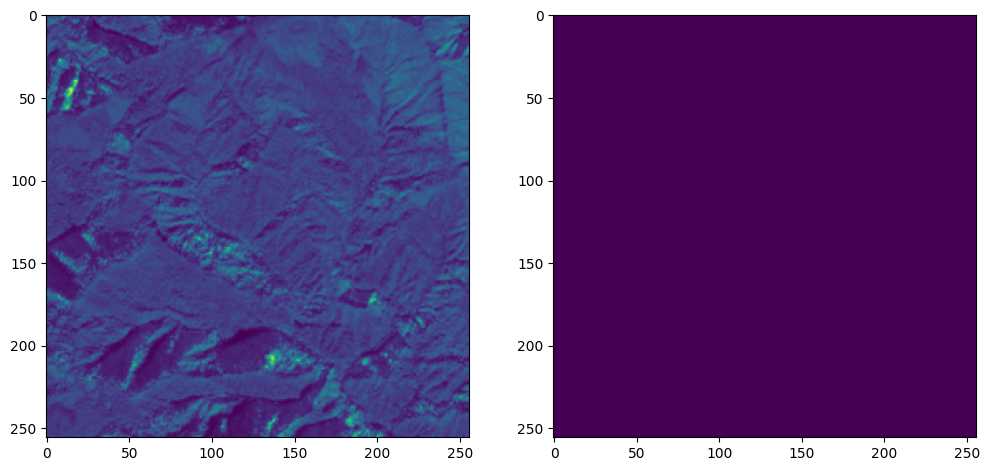

62


In [3]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(train_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [4]:
test_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\testing_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      test_images.append(X)

test_images = np.array(test_images)
print(np.mean(test_images))
# normalize
# test_images = test_images / (2**16-1)
# test_images = test_images.astype(int)
# low, high = np.percentile(X, (2, 98))
# test_images = (test_images-low)/(high-low)
print(test_images.shape)

test_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\binary\truth_2\testing\images/*.tif")
image_names.sort()
for img_path in image_names:
  #  print(img_path)
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   test_masks.append(band1)

test_masks = np.array(test_masks)
# test_masks = test_masks
# masks = train_masks.astype(int)
print(np.unique(test_masks))

y_test_cat = to_categorical(test_masks, num_classes=2)
y_test_cat = y_test_cat.astype(int)
print(y_test_cat.shape)
print(np.unique(y_test_cat))

1314.3571367617008
(36, 256, 256, 3)
[0 1]
(36, 256, 256, 2)
[0 1]


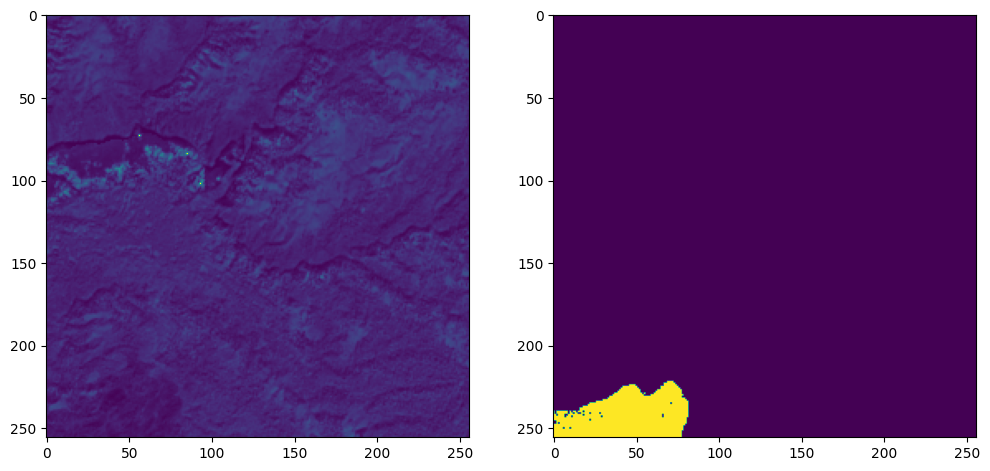

10


In [5]:
# #Sanity check, view few images
image_number = random.randint(0, len(test_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((test_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(test_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation

# Define the FCN model
def FCN(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Input
    inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    upconv3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(pool3)
    upconv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(upconv3)
    upconv3 = BatchNormalization()(upconv3)
    upconv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(upconv3)
    upconv3 = BatchNormalization()(upconv3)

    upconv2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(upconv3)
    upconv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(upconv2)
    upconv2 = BatchNormalization()(upconv2)
    upconv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(upconv2)
    upconv2 = BatchNormalization()(upconv2)

    upconv1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(upconv2)
    upconv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(upconv1)
    upconv1 = BatchNormalization()(upconv1)
    upconv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(upconv1)
    upconv1 = BatchNormalization()(upconv1)

    # Output
    outputs = Conv2D(n_classes, (1, 1), activation='softmax', padding='same')(upconv1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [7]:
import tensorflow as tf
from keras import backend as K

def categorical_mean_iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)  # Convert y_true to the same data type as y_pred

    # Calculate intersection and union
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection

    # Calculate mean IoU loss
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    mean_iou_loss = 1 - K.mean(iou)

    return mean_iou_loss

In [8]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [9]:
from keras.callbacks import Callback

# Custom callback to stop training at a specific validation accuracy
class StopAtValidationAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopAtValidationAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_my_mean_iou'] >= self.target_accuracy:
            self.model.stop_training = True
            print(f"\nReached target validation accuracy ({self.target_accuracy}), stopping training!")

# Define the custom callback with the desired target validation accuracy
target_accuracy = 0.84
stop_at_accuracy = StopAtValidationAccuracy(target_accuracy)

In [10]:
# training
opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
# def get_model():
#     return multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
# def get_model():
#     return Attention_UNet((256, 256, 3))
def get_model():
    return FCN(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
# def get_model():
#     return Attention_ResUNet_stacked((256, 256, 9))
model = get_model()
model.compile(optimizer = 'adam', loss=categorical_mean_iou_loss, metrics = [MyMeanIOU(2)])
# tf.keras.losses.CategoricalCrossentropy()
# categorical_focal_loss(gamma=2.0, alpha=0.25)

In [11]:
# fitting model
import time
start_time = time.time()
history = model.fit(train_images, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=50,
                    validation_data=(test_images, y_test_cat),
                    callbacks=[stop_at_accuracy],
                    shuffle=True)

end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: {:.2f} seconds".format(elapsed_time))

Epoch 1/50
87/87 [==============================] - 27s 215ms/step - loss: 0.5613 - my_mean_iou: 0.6268 - val_loss: 0.4429 - val_my_mean_iou: 0.7278
Epoch 2/50
87/87 [==============================] - 16s 181ms/step - loss: 0.5260 - my_mean_iou: 0.6973 - val_loss: 0.3904 - val_my_mean_iou: 0.8085
Epoch 3/50
87/87 [==============================] - 16s 181ms/step - loss: 0.5359 - my_mean_iou: 0.6669 - val_loss: 0.3854 - val_my_mean_iou: 0.8229
Epoch 4/50
87/87 [==============================] - 16s 181ms/step - loss: 0.5187 - my_mean_iou: 0.7125 - val_loss: 0.5390 - val_my_mean_iou: 0.5419
Epoch 5/50
87/87 [==============================] - 16s 181ms/step - loss: 0.5204 - my_mean_iou: 0.7125 - val_loss: 0.3980 - val_my_mean_iou: 0.7965
Epoch 6/50
87/87 [==============================] - 16s 181ms/step - loss: 0.5228 - my_mean_iou: 0.7026 - val_loss: 0.3997 - val_my_mean_iou: 0.7871
Epoch 7/50
87/87 [==============================] - 16s 181ms/step - loss: 0.5206 - my_mean_iou: 0.7022 - 

In [12]:
model.save(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\models_new\binary\fcn_binary.h5")

In [12]:
from sklearn.metrics import classification_report
from sklearn import metrics
import tensorflow as tf
predicted = np.expand_dims(test_images, 0)
prediction = (model.predict(test_images))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
y_test_pred = test_masks
# print(y_test.shape)
print(predicted_img.shape)
cm = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print(cm, "\n")
print(classification_report(y_test_pred.reshape(-1), predicted_img.reshape(-1), digits=4))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Mean IoU = ", IOU_keras.result().numpy())
values = np.array(IOU_keras.get_weights()).reshape(2, 2)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2] + values[1,2] + values[3,2])
# class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3] + values[1,3] + values[2,3])
print("class1 IoU = ", class1_IoU)
print("class2 IoU = ", class2_IoU)
# print("class3 IoU = ", class3_IoU)
# print("class4 IoU = ", class4_IoU)
from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Kappa:", kappa_score)

2/2 [==============================] - 5s 29ms/step
(36, 256, 256, 2)
(36, 256, 256)
[[1545183   95059]
 [  79401  639653]] 
              precision    recall  f1-score   support

           0     0.9511    0.9420    0.9466   1640242
           1     0.8706    0.8896    0.8800    719054

    accuracy                         0.9261   2359296
   macro avg     0.9109    0.9158    0.9133   2359296
weighted avg     0.9266    0.9261    0.9263   2359296

Mean IoU =  0.8421271
class1 IoU =  0.8985487
class2 IoU =  0.78570545
Kappa: 0.8265671686813696


1/1 [==============================] - 0s 18ms/step


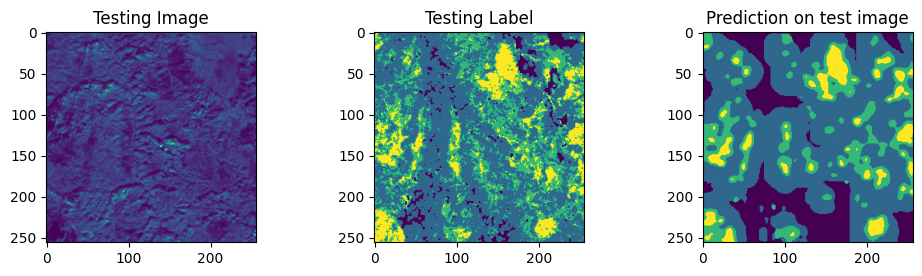

In [21]:
#Randomly check on train images
image_number = random.randint(0, len(train_images)-1)
predicted = np.expand_dims(train_images[image_number], 0)
prediction = (model.predict(predicted))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
# print(prediction[0, 0, :, :])
# print(prediction[0, 1, 1, :])
# print(predicted_img)
plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(np.reshape((predicted_img), (256, 256, 1)))
plt.show()